In [1]:
%load_ext memory_profiler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
#from glob import glob
from pathlib import Path
import os

import xarray as xr
from xorca.lib import load_xorca_dataset

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client


Client Scheduler: tcp://127.0.0.1:54751 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 5.59 GiB


In [3]:
data_path = Path("/Users/nlahaye/tmp/eNATL_COSNWA")

data_fname = "eNATL60COSNWA-BLB002_y2009m07d??.1h_*_0-1000m.nc"
grid_fname = "mesh_mask_eNATL60_subdom.nc"

data_files = list(data_path.glob(data_fname))
grid_files = list(data_path.glob(grid_fname))

In [4]:
%%time
%%memit
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 28.2 GB
peak memory: 567.30 MiB, increment: 430.81 MiB
CPU times: user 14.4 s, sys: 428 ms, total: 14.8 s
Wall time: 15.8 s


In [5]:
ds_tot

<xarray.Dataset>
Dimensions:   (t: 744, x_c: 121, x_r: 121, y_c: 146, y_r: 146, z_c: 107, z_l: 107)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 100 101 102 103 104 105 106 107
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 103.5 104.5 105.5 106.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 139 140 141 142 143 144 145 146
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 143.5 144.5 145.5 146.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(146, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 146, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 146, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 146, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 146, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 146, 121), meta=np.ndarray>
Data variables:
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 146, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 146, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 146, 121), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 146, 121), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 146, 121), meta=np.ndarray>

peak memory: 606.43 MiB, increment: 29.55 MiB
CPU times: user 3.37 s, sys: 355 ms, total: 3.72 s
Wall time: 6.98 s


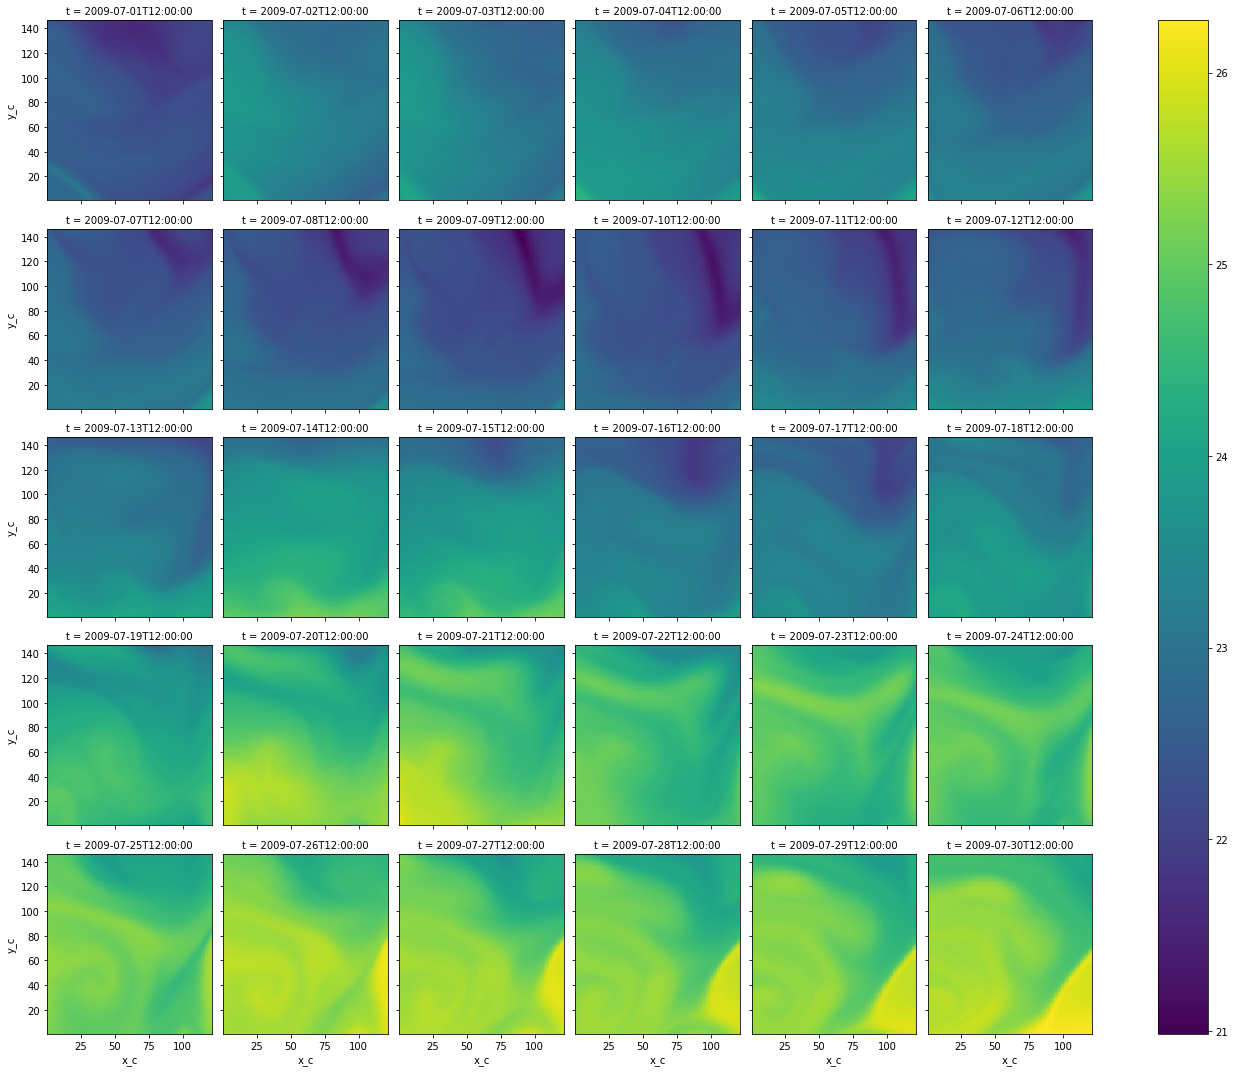

In [12]:
%%time
%%memit
ds_tot.votemper.isel(z_c=0).coarsen(t=24).mean().isel(t=slice(0,-1)).plot(col="t", col_wrap=6)